# LangGraph Graph API

LangGraph Graph API는 노드(nodes)와 엣지(edges)로 구성된 상태 기반 워크플로우를 정의하는 시스템입니다.

## 주요 구성 요소

- **State**: 그래프 실행 중 데이터를 저장하는 상태 객체
- **Nodes**: 실제 작업을 수행하는 함수들
- **Edges**: 노드 간의 연결과 실행 흐름을 정의

## 실행 모델

LangGraph는 Google의 Pregel 시스템 기반의 super-step 방식으로 동작합니다:
- 각 super-step에서 하나 이상의 노드를 실행
- 동일 단계의 노드들은 병렬 처리 가능
- 모든 노드 실행 완료 시 그래프 종료

## 환경 설정

LangGraph를 사용하기 위해 필요한 환경 변수와 로깅을 설정합니다. `.env` 파일에 API 키를 저장하고, LangSmith를 통해 실행 과정을 추적할 수 있습니다.

아래 코드는 환경 변수를 로드하고 LangSmith 프로젝트를 설정합니다.

In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

# 환경 변수 로드
load_dotenv(override=True)
# 추적을 위한 프로젝트 이름 설정
logging.langsmith("LangChain-V1-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangChain-V1-Tutorial


---

## 그래프 기본 개념

### 그래프 구조

LangGraph의 그래프는 다음 3가지 핵심 구성요소로 이루어집니다:

**State (상태)**
- 그래프 실행 중 데이터를 저장하는 객체
- 노드 간 데이터 전달 및 공유에 사용

**Nodes (노드)**
- 실제 작업을 수행하는 함수
- State를 입력받아 처리 후 업데이트된 State 반환

**Edges (엣지)**
- 노드 간 실행 흐름을 정의
- 다음 실행할 노드를 결정

### 실행 방식

- **Super-step**: 한 번에 하나의 작업 단계 실행
- **병렬 처리**: 동일 단계의 여러 노드를 동시 실행 가능
- **순차 기록**: 각 단계의 결과를 순서대로 기록

In [2]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict


# 간단한 그래프 예제
class SimpleState(TypedDict):
    """단일 필드를 가진 간단한 상태"""

    message: str


# StateGraph 생성
graph_builder = StateGraph(SimpleState)


# 노드 함수 정의
def processor(state: SimpleState):
    """상태의 메시지를 처리하는 노드 함수"""
    # 노드는 현재 상태를 입력으로 받고 업데이트를 반환
    return {"message": state["message"] + " - processed"}


# 노드 추가
graph_builder.add_node("processor", processor)

# 엣지 추가 (진입점과 종료점)
graph_builder.add_edge(START, "processor")
graph_builder.add_edge("processor", END)

# 그래프 컴파일 - 필수!
graph = graph_builder.compile()

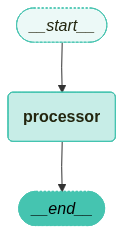

In [3]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [4]:
# 그래프 실행
result = graph.invoke({"message": "Hello LangGraph"})
print(f"결과: {result}")

결과: {'message': 'Hello LangGraph - processed'}


### 그래프 컴파일

그래프는 실행 전에 컴파일 과정을 거쳐야 합니다.

**컴파일 과정**

1. **구조 검증**: 노드 연결 및 실행 경로 유효성 확인
2. **설정 적용**: checkpointer, interrupt 등의 옵션 적용
3. **실행 객체 생성**: 최적화된 실행 가능 객체 생성

**컴파일 옵션**

| 옵션 | 설명 |
|------|------|
| `checkpointer` | 그래프 실행 중 상태 저장 |
| `interrupt_before` | 특정 노드 실행 전 일시정지 |
| `interrupt_after` | 특정 노드 실행 후 일시정지 |

In [5]:
from langgraph.checkpoint.memory import InMemorySaver

# 체크포인터와 함께 컴파일
memory = InMemorySaver()

graph_with_memory = graph_builder.compile(
    checkpointer=memory,  # 상태 저장을 위한 체크포인터
    # interrupt_before=["processor"],  # 특정 노드 전에 중단 (디버깅용)
    # interrupt_after=["processor"],   # 특정 노드 후에 중단
)

print("체크포인터가 있는 그래프 컴파일 완료!")

✅ 체크포인터가 있는 그래프 컴파일 완료!


---

## State 심화

### State 개념

State는 그래프의 데이터 저장소로, 노드 간 데이터 전달 및 공유에 사용됩니다.

### State 정의 방법

**1. TypedDict 방식 (권장)**
```python
class MyState(TypedDict):
    name: str
    count: int
```
- 장점: 간결, 빠른 성능
- 단점: 기본값 설정 불편

**2. Dataclass 방식**
```python
@dataclass
class MyState:
    name: str = "기본값"
    count: int = 0
```
- 장점: 기본값 설정 용이
- 단점: TypedDict보다 오버헤드 존재

**3. Pydantic 방식**
```python
class MyState(BaseModel):
    name: str = "기본값"
    count: int = 0
```
- 장점: 데이터 유효성 검증
- 단점: 가장 무거움

In [6]:
from typing import Annotated, List
from dataclasses import dataclass, field
from pydantic import BaseModel


# 방법 1: TypedDict (가장 일반적, 성능 우수)
class TypedDictState(TypedDict):
    """TypedDict를 사용한 상태 정의"""

    count: int
    items: List[str]


# 방법 2: dataclass (기본값 지원)
@dataclass
class DataclassState:
    """기본값을 지원하는 dataclass 상태 정의"""

    count: int = 0
    items: List[str] = field(default_factory=list)


# 방법 3: Pydantic (재귀적 검증, 성능은 떨어짐)
class PydanticState(BaseModel):
    """데이터 검증을 위한 Pydantic 상태 정의"""

    count: int = 0
    items: List[str] = []


print("세 가지 방식의 State 스키마 정의 완료!")

✅ 세 가지 방식의 State 스키마 정의 완료!


### Reducers

Reducer는 State 업데이트 시 새 값과 기존 값을 병합하는 규칙을 정의합니다.

**Reducer 종류**

| Reducer | 동작 | 사용 예시 |
|---------|------|-----------|
| 기본 (None) | 새 값으로 덮어쓰기 | 설정값, 현재 상태 |
| `add` | 기존 값에 추가 | 메시지 목록, 로그 |
| 커스텀 함수 | 사용자 정의 로직 | 최대값 유지, 조건부 병합 |

**사용 예시**

```python
from typing import Annotated
from operator import add

class State(TypedDict):
    value: int  # 기본 리듀서: 덮어쓰기
    messages: Annotated[List[str], add]  # add 리듀서: 추가
    max_score: Annotated[int, lambda old, new: max(old, new)]  # 커스텀
```

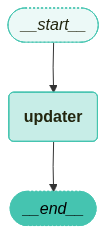

In [7]:
from operator import add


# 기본 리듀서 vs 커스텀 리듀서
class StateWithReducers(TypedDict):
    """커스텀 리듀서가 포함된 상태 정의"""

    # 기본 리듀서: 값을 덮어씀
    current_value: int

    # add 리듀서: 리스트를 연결
    history: Annotated[List[str], add]

    # 커스텀 리듀서: 최대값 유지
    max_value: Annotated[int, lambda x, y: max(x, y)]


# 그래프 생성
builder = StateGraph(StateWithReducers)


def update_values(state: StateWithReducers):
    """상태 값들을 업데이트하는 노드 함수"""
    return {
        "current_value": 10,  # 덮어쓰기
        "history": ["새 항목"],  # 추가
        "max_value": 15,  # 최대값과 비교
    }


builder.add_node("updater", update_values)
builder.add_edge(START, "updater")
builder.add_edge("updater", END)

graph = builder.compile()

# 그래프 시각화
visualize_graph(graph)

In [8]:
# 초기 상태로 실행
initial_state = {"current_value": 5, "history": ["초기 항목"], "max_value": 20}

result = graph.invoke(initial_state)
print("\n리듀서 적용 결과:")
print(f"  current_value: 5 → {result['current_value']} (덮어쓰기)")
print(f"  history: {result['history']} (추가)")
print(f"  max_value: {result['max_value']} (최대값 유지)")


리듀서 적용 결과:
  current_value: 5 → 10 (덮어쓰기)
  history: ['초기 항목', '새 항목'] (추가)
  max_value: 20 (최대값 유지)


### 메시지 처리

대화형 AI 애플리케이션에서 메시지 이력을 관리하는 방법입니다.

**메시지 관리 방법**

**방법 1: add_messages 리듀서**
```python
class ChatState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
```

**방법 2: MessagesState 상속 (권장)**
```python
class ExtendedChatState(MessagesState):
    # messages 필드 자동 포함
    metadata: dict
```

**메시지 타입**

- `HumanMessage`: 사용자 메시지
- `AIMessage`: AI 응답
- `SystemMessage`: 시스템 지시사항
- `ToolMessage`: 도구 실행 결과

In [9]:
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState


# 방법 1: add_messages 리듀서 사용
class ChatState(TypedDict):
    """메시지 처리를 위한 상태 정의"""

    messages: Annotated[List[AnyMessage], add_messages]
    metadata: dict


# 방법 2: MessagesState 상속 (더 간단)
class ExtendedChatState(MessagesState):
    """MessagesState를 상속한 확장 상태 정의"""

    # messages 키는 이미 정의되어 있음
    metadata: dict

In [10]:
from langchain_core.runnables import RunnableConfig

# 메시지 처리 예제
builder = StateGraph(ChatState)


def process_chat(state: ChatState):
    """채팅 메시지를 처리하는 노드 함수"""
    # 마지막 메시지 접근
    last_message = state["messages"][-1]

    # 응답 생성
    response = AIMessage(content=f"{last_message.content}")

    return {
        "messages": [response],  # add_messages가 자동으로 추가
        "metadata": {"processed": True},
    }


builder.add_node("chat", process_chat)
builder.add_edge(START, "chat")
builder.add_edge("chat", END)

memory = InMemorySaver()

chat_graph = builder.compile(checkpointer=memory)

In [11]:
config = RunnableConfig(configurable={"thread_id": "1"})

# 실행
result = chat_graph.invoke(
    {
        "messages": [HumanMessage(content="안녕하세요")],
        "metadata": {},
        "user_info": {"name": "사용자"},
    },
    config=config,
)

print("\n메시지 처리 결과:")
for msg in result["messages"]:
    print(f"  [{msg.__class__.__name__}]: {msg.content}")


메시지 처리 결과:
  [HumanMessage]: 안녕하세요
  [AIMessage]: 안녕하세요


### 다중 스키마

그래프의 입력, 내부 처리, 출력에 각각 다른 스키마를 사용할 수 있습니다.

**스키마 종류**

**InputState**
- 그래프 시작 시 사용자가 제공하는 데이터 형태

**InternalState**
- 그래프 내부 노드들이 사용하는 데이터 구조

**OutputState**
- 그래프 완료 시 반환되는 데이터 형태

**사용 목적**

- **보안**: 내부 처리 로직을 외부에 노출하지 않음
- **단순화**: 사용자는 필요한 정보만 제공
- **유연성**: 내부 구조 변경 시 외부 인터페이스 유지 가능

In [12]:
# 그래프의 입력 스키마
class InputState(TypedDict):
    """입력 스키마 - 사용자가 제공하는 데이터"""

    user_input: str


# 그래프의 출력 스키마
class OutputState(TypedDict):
    """출력 스키마 - 사용자가 받는 데이터"""

    graph_output: str


# 내부에서 사용되는 State
class InternalState(TypedDict):
    """내부 스키마 - 처리를 위한 전체 상태"""

    user_input: str
    internal_state: str


# Private State
class PrivateState(TypedDict):
    """프라이빗 스키마 - 내부 노드 간 통신용"""

    private_state: str

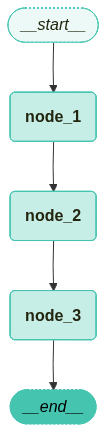

node_1: {'user_input': '사용자 입력'}
node_2: {'user_input': '사용자 입력', 'internal_state': '사용자 입력(node_1 에서 처리됨)'}
node_3: {'private_state': 'PRIVATE: 사용자 입력(node_1 에서 처리됨) (node_2 에서 처리됨)'}

다중 스키마 결과: {'graph_output': '최종 결과: PRIVATE: 사용자 입력(node_1 에서 처리됨) (node_2 에서 처리됨) (node_3 에서 처리됨)'}


In [13]:
# 다중 스키마를 사용하는 그래프
builder = StateGraph(
    InternalState,
    input_schema=InputState,  # 입력 스키마 지정
    output_schema=OutputState,  # 출력 스키마 지정
)


def node_1(state: InputState) -> InternalState:
    """첫 번째 노드 - InputState를 읽고 InternalState에 씀"""
    # InputState를 받지만 InternalState의 키에 쓸 수 있음
    print(f"node_1: {state}")
    return {
        "user_input": state["user_input"],
        "internal_state": state["user_input"] + "(node_1 에서 처리됨)",
    }


def node_2(state: InternalState) -> PrivateState:
    """두 번째 노드 - InternalState를 읽고 PrivateState에 씀"""
    print(f"node_2: {state}")
    # 새로운 state 채널(temp_data) 추가 가능
    return {"private_state": f"PRIVATE: {state['internal_state']} (node_2 에서 처리됨)"}


def node_3(state: PrivateState) -> OutputState:
    """세 번째 노드 - PrivateState를 읽고 OutputState에 씀"""
    print(f"node_3: {state}")
    return {"graph_output": f"최종 결과: {state['private_state']} (node_3 에서 처리됨)"}


# 노드와 엣지 추가
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

multi_schema_graph = builder.compile()

visualize_graph(multi_schema_graph)

# 실행 - 입력은 InputState 형식
result = multi_schema_graph.invoke({"user_input": "사용자 입력"})

# 출력은 OutputState 형식
print(f"\n다중 스키마 결과: {result}")

---

## Nodes 심화

### 노드 개념

노드는 그래프에서 실제 작업을 수행하는 함수입니다.

### 노드 함수 매개변수

노드 함수는 최대 3가지 매개변수를 받을 수 있습니다:

| 매개변수 | 타입 | 설명 |
|----------|------|------|
| `state` | State | 현재 그래프 상태 (필수) |
| `config` | RunnableConfig | 실행 시점 설정 정보 (선택) |
| `store` | BaseStore | 런타임 리소스 접근 (선택) |

**사용 예시**

```python
# state만 사용
def simple_node(state: MyState):
    return {"count": state["count"] + 1}

# state + config 사용
def config_node(state: MyState, config: RunnableConfig):
    user_id = config["configurable"]["user_id"]
    return {"user": user_id}

# 모든 매개변수 사용
def advanced_node(state: MyState, config: RunnableConfig, *, store: BaseStore):
    data = store.get(state["key"])
    return {"data": data}
```

### Config 스키마

ConfigSchema는 노드가 받을 수 있는 설정값의 타입을 정의합니다. TypedDict나 dataclass를 사용하여 스키마를 정의하면, 잘못된 설정 키 이름을 방지하고 타입 안전성을 보장받을 수 있습니다.

아래 코드는 ConfigSchema를 정의하고 노드에서 활용하는 방법을 보여줍니다.

In [14]:
from typing_extensions import TypedDict


class ConfigSchema(TypedDict):
    my_runtime_value: str
    another_setting: bool


class MyState(MessagesState):
    pass

### Config를 통한 정보 전달

노드는 `config` 매개변수를 통해 실행 시점의 설정 정보를 받을 수 있습니다.

**config 구조**

```python
config = {
    "configurable": {
        "thread_id": "session_123",
        "user_id": "user_456",
        # 사용자 정의 설정값들
    }
}
```

In [15]:
from langchain_core.runnables import RunnableConfig


# state 와 config 를 받는 노드 함수 정의
def my_node(state: MyState, config: RunnableConfig):
    """커스텀 설정 값에 접근하는 방법을 보여주는 노드 함수

    Args:
        state (MyState): 그래프의 현재 상태
        config (RunnableConfig): 런타임 및 사용자 정의 설정을 포함하는 구성 객체

    Returns:
        dict: 업데이트된 상태 딕셔너리
    """
    # config["configurable"] 딕셔너리에서 사용자 정의 설정값을 가져옵니다.
    runtime_value = config["configurable"].get("runtime_value", "")
    setting_value = config["configurable"].get("setting_value", "")

    # runtime_value 값이 있으면 해당 값을 출력합니다.
    if runtime_value:
        print(f"runtime_value: {runtime_value}")

    # setting_value 값이 있으면 해당 값을 출력합니다.
    if setting_value:
        print(f"setting_value: {setting_value}")

    # 현재 state 값을 출력합니다.
    print(f"state: {state}")

    # 새로운 키와 값을 포함하는 상태를 반환합니다.
    return {"updated_key": "new_value"}

### 그래프에 Config 스키마 연결

`context_schema`를 지정하여 설정값을 자동으로 검증할 수 있습니다.

**장점**

- 잘못된 설정 키 이름 방지
- 타입 안전성 보장
- IDE 자동완성 지원
- 명확한 문서화

In [16]:
from langgraph.graph import StateGraph

builder = StateGraph(MyState, context_schema=ConfigSchema)
builder.add_node("my_node", my_node)
builder.add_edge(START, "my_node")
builder.add_edge("my_node", END)

graph = builder.compile()

### Config 값 전달

그래프 실행 시 `config` 매개변수를 통해 설정값을 전달합니다.

```python
graph.invoke(
    {"messages": [...]},
    config={
        "configurable": {
            "runtime_value": "I love LangGraph",
            "setting_value": 100
        }
    }
)
```

설정값은 `config["configurable"]` 내에 전달해야 합니다.

In [17]:
graph = builder.compile()
result = graph.invoke(
    {"messages": [HumanMessage(content="안녕하세요")]},
    config={
        "configurable": {"runtime_value": "I love LangGraph", "setting_value": 123}
    },
)

runtime_value: I love LangGraph
setting_value: 123
state: {'messages': [HumanMessage(content='안녕하세요', additional_kwargs={}, response_metadata={}, id='a5250236-99e6-42e2-8436-d96520d4b1cb')]}


### START와 END 노드

모든 그래프는 시작점과 종료점을 가집니다.

**START 노드**
- 그래프 실행의 시작점
- 사용자 입력을 첫 번째 노드로 전달
- LangGraph가 자동으로 제공

**END 노드**
- 그래프 실행의 종료점
- 최종 결과를 반환
- 여러 노드에서 END로 연결 가능

**사용 예시**

```python
# 기본 플로우
builder.add_edge(START, "first_node")
builder.add_edge("last_node", END)

# 조건부 종료
builder.add_edge("validation_node", END)
builder.add_edge("retry_node", "first_node")
```

In [18]:
# START와 END 사용 예제
class FlowState(TypedDict):
    """흐름 제어 예제를 위한 상태 정의"""

    value: int
    path: List[str]


builder = StateGraph(FlowState)


def start_processing(state: FlowState):
    """초기 처리 노드"""
    return {"value": state["value"] * 2, "path": ["start"]}


def middle_processing(state: FlowState):
    """중간 처리 노드"""
    return {"value": state["value"] + 10, "path": state["path"] + ["middle"]}


def final_processing(state: FlowState):
    """최종 처리 노드"""
    return {"value": state["value"] // 2, "path": state["path"] + ["final"]}


# 노드 추가
builder.add_node("start_node", start_processing)
builder.add_node("middle_node", middle_processing)
builder.add_node("final_node", final_processing)

# 플로우 정의
builder.add_edge(START, "start_node")  # 진입점
builder.add_edge("start_node", "middle_node")
builder.add_edge("middle_node", "final_node")
builder.add_edge("final_node", END)  # 종료점

flow_graph = builder.compile()

# 실행
result = flow_graph.invoke({"value": 5, "path": []})
print(f"\n플로우 실행 결과:")
print(f"  초기값: 5")
print(f"  최종값: {result['value']}")
print(f"  경로: {' → '.join(result['path'])}")


플로우 실행 결과:
  초기값: 5
  최종값: 10
  경로: start → middle → final


### 노드 캐싱

노드 캐싱은 계산 결과를 저장하여 재사용하는 최적화 기법입니다.

**CachePolicy 설정**

**ttl (Time To Live)**
```python
ttl=60  # 60초 동안 캐시 유지
ttl=None  # 무제한 캐시 유지
```

**key_func (캐시 키 생성)**
```python
# 기본: 전체 입력을 키로 사용
key_func=None

# 커스텀: 특정 필드만 키로 사용
key_func=lambda state: hash(state["user_id"])
```

**사용 시나리오**

- 계산이 오래 걸리는 작업
- 결과가 자주 반복되는 경우
- 외부 API 호출 비용 절감
- 자주 조회되는 데이터베이스 쿼리

In [19]:
import time
from langgraph.cache.memory import InMemoryCache
from langgraph.types import CachePolicy


class CacheState(TypedDict):
    """캐싱 예제를 위한 상태 정의"""

    x: int
    result: int


builder = StateGraph(CacheState)


def expensive_computation(state: CacheState) -> dict:
    """캐싱이 필요한 무거운 계산 노드"""
    print(f"  무거운 계산 실행 중... (x={state['x']})")
    time.sleep(3)  # 무거운 작업 시뮬레이션
    return {"result": state["x"] * state["x"]}


# 캐시 정책과 함께 노드 추가
builder.add_node(
    "expensive_node",
    expensive_computation,
    cache_policy=CachePolicy(
        ttl=None,  # 60초 동안 캐시 유지, None 이면 만료시간 없음
        # key_func=lambda x: hash(x["x"])  # 커스텀 캐시 키 생성 함수
    ),
)

builder.add_edge(START, "expensive_node")
builder.add_edge("expensive_node", END)

# 캐시와 함께 컴파일
cached_graph = builder.compile(cache=InMemoryCache())

print("\n캐싱 테스트:")
print("첫 번째 실행")
start_time = time.time()
result1 = cached_graph.invoke({"x": 10})
print(f"  결과: {result1['result']}, 소요 시간: {time.time() - start_time:.1f}초")

print("\n두 번째 실행")
start_time = time.time()
result2 = cached_graph.invoke({"x": 10})
print(f"  결과: {result2['result']}, 소요 시간: {time.time() - start_time:.1f}초")

print("\n다른 입력으로 실행")
start_time = time.time()
result3 = cached_graph.invoke({"x": 20})
print(f"  결과: {result3['result']}, 소요 시간: {time.time() - start_time:.1f}초")


캐싱 테스트:
첫 번째 실행
  🔄 무거운 계산 실행 중... (x=10)
  결과: 100, 소요 시간: 3.0초

두 번째 실행
  결과: 100, 소요 시간: 0.0초

다른 입력으로 실행
  🔄 무거운 계산 실행 중... (x=20)
  결과: 400, 소요 시간: 3.0초


In [20]:
print("\n캐싱 테스트:")

result1 = None
%time result1 = cached_graph.invoke({"x": 10})
print(f"  결과: {result1['result']}")


캐싱 테스트:
CPU times: user 750 μs, sys: 318 μs, total: 1.07 ms
Wall time: 799 μs
  결과: 100


---

## Edges 심화

엣지는 노드 간 실행 흐름을 정의합니다.

### 엣지 종류

**Normal Edges (일반 엣지)**
- 항상 동일한 노드로 이동
- 고정된 실행 순서

**Conditional Edges (조건부 엣지)**
- 상태에 따라 다음 노드 결정
- 동적 라우팅

**Parallel Edges (병렬 엣지)**
- 여러 노드를 동시 실행
- 성능 최적화

### 일반 엣지

일반 엣지는 항상 동일한 경로로 실행됩니다.

```python
builder.add_edge("node_a", "node_b")
```

In [21]:
class EdgeState(TypedDict):
    """엣지 예제를 위한 상태 정의"""

    value: int
    history: List[str]


builder = StateGraph(EdgeState)


# 노드 정의
def node_a(state: EdgeState):
    """노드 A"""
    return {"value": state["value"] + 1, "history": state["history"] + ["A"]}


def node_b(state: EdgeState):
    """노드 B"""
    return {"value": state["value"] * 2, "history": state["history"] + ["B"]}


def node_c(state: EdgeState):
    """노드 C"""
    return {"value": state["value"] - 3, "history": state["history"] + ["C"]}


# 노드 추가
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)

# 일반 엣지 - 항상 A → B → C 순서로 실행
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", END)

normal_edge_graph = builder.compile()

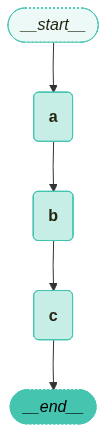

In [22]:
# 그래프 시각화
visualize_graph(normal_edge_graph)

In [23]:
result = normal_edge_graph.invoke({"value": 10, "history": []})
print(f"일반 엣지 결과:")
print(f"  경로: {' → '.join(result['history'])}")
print(f"  최종값: {result['value']}")

일반 엣지 결과:
  경로: A → B → C
  최종값: 19


### 조건부 엣지

조건부 엣지는 상태를 기반으로 다음 노드를 동적으로 결정합니다.

```python
def routing_function(state):
    if state["urgency"] == "high":
        return "intensive_care"
    elif state["urgency"] == "medium":
        return "general_care"
    else:
        return "outpatient_care"

builder.add_conditional_edges(
    "triage_node",
    routing_function
)
```

**사용 시나리오**

- 성공/실패에 따른 분기 처리
- 사용자 타입별 차별화된 처리
- 데이터 크기에 따른 처리 방식 변경
- 오류 타입별 복구 전략

In [24]:
from typing import Literal

builder = StateGraph(EdgeState)

# 노드들 재사용
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)


# 라우팅 함수 정의
def routing_function(state: EdgeState) -> Literal["b", "c"]:
    """상태 값에 따라 라우팅 결정"""
    if state["value"] > 15:
        return "b"  # 큰 값은 B로
    else:
        return "c"  # 작은 값은 C로


# 조건부 엣지 추가
builder.add_edge(START, "a")
builder.add_conditional_edges("a", routing_function)  # 소스 노드  # 라우팅 함수
builder.add_edge("b", END)
builder.add_edge("c", END)

conditional_graph = builder.compile()

# 다른 값으로 테스트
print("조건부 라우팅 테스트:\n")

for initial_value in [10, 20]:
    result = conditional_graph.invoke({"value": initial_value, "history": []})
    print(f"초기값 {initial_value}:")
    print(f"  경로: {' → '.join(result['history'])}")
    print(f"  최종값: {result['value']}\n")

조건부 라우팅 테스트:

초기값 10:
  경로: A → C
  최종값: 8

초기값 20:
  경로: A → B
  최종값: 42



### 매핑 기반 조건부 엣지

복잡한 조건을 매핑 테이블로 정리하여 관리할 수 있습니다.

```python
def categorize(state):
    # 카테고리 분류 로직
    return category_name

category_mapping = {
    "premium": "vip_handler",
    "standard": "normal_handler",
    "basic": "basic_handler"
}

builder.add_conditional_edges(
    "categorizer",
    categorize,
    category_mapping
)
```

**장점**

- 가독성 향상
- 유지보수 용이
- 확장성 개선

In [25]:
# 매핑을 사용한 더 복잡한 라우팅
builder = StateGraph(EdgeState)

builder.add_node(
    "start", lambda s: {"value": s["value"], "history": s["history"] + ["start"]}
)
builder.add_node(
    "process_high",
    lambda s: {"value": s["value"] * 10, "history": s["history"] + ["high"]},
)
builder.add_node(
    "process_medium",
    lambda s: {"value": s["value"] * 5, "history": s["history"] + ["medium"]},
)
builder.add_node(
    "process_low",
    lambda s: {"value": s["value"] * 2, "history": s["history"] + ["low"]},
)


def categorize_value(state: EdgeState) -> str:
    """값을 high/medium/low로 분류"""
    if state["value"] > 100:
        return "high"
    elif state["value"] > 50:
        return "medium"
    else:
        return "low"


# 매핑을 사용한 조건부 엣지
builder.add_edge(START, "start")
builder.add_conditional_edges(
    "start",
    categorize_value,
    {"high": "process_high", "medium": "process_medium", "low": "process_low"},
)

# 모든 처리 노드는 END로
for node in ["process_high", "process_medium", "process_low"]:
    builder.add_edge(node, END)

mapped_graph = builder.compile()

# 테스트
print("매핑 기반 라우팅 테스트:\n")
for value in [30, 75, 150]:
    result = mapped_graph.invoke({"value": value, "history": []})
    print(f"초기값 {value}: {' → '.join(result['history'])}, 결과: {result['value']}")

매핑 기반 라우팅 테스트:

초기값 30: start → low, 결과: 60
초기값 75: start → medium, 결과: 375
초기값 150: start → high, 결과: 1500


### 병렬 실행

여러 노드를 동시에 실행하여 처리 시간을 단축할 수 있습니다.

**병렬 실행 조건**

하나의 노드에서 여러 노드로 나가는 엣지가 있으면 자동으로 병렬 실행됩니다.

```python
def parallel_routing(state):
    return ["parallel_a", "parallel_b", "parallel_c"]

builder.add_conditional_edges("splitter", parallel_routing)
```

**장점**

- 처리 시간 단축
- 리소스 활용 극대화
- 처리량 향상

**주의사항**

- 작업 간 의존성이 없어야 함
- 공유 리소스 접근 시 동기화 필요
- 실행 순서가 중요한 작업에는 부적합

In [26]:
from typing import List


class ParallelState(TypedDict):
    """병렬 실행을 위한 상태 정의"""

    input: int
    nodes: str
    results: Annotated[List[AnyMessage], add_messages]


builder = StateGraph(ParallelState)


def splitter(state: ParallelState):
    """여러 경로로 분할하는 노드"""
    return {"results": ["분할 완료"]}


def parallel_a(state: ParallelState):
    """병렬 처리 A 노드"""
    print("[Node A]")
    time.sleep(0.5)  # 작업 시뮬레이션
    return {"results": [f"A: {state['input'] * 2}"]}


def parallel_b(state: ParallelState):
    """병렬 처리 B 노드"""
    print("[Node B]")
    time.sleep(1.0)  # 작업 시뮬레이션
    return {"results": [f"B: {state['input'] + 10}"]}


def parallel_c(state: ParallelState):
    """병렬 처리 C 노드"""
    print("[Node C]")
    time.sleep(2.0)  # 작업 시뮬레이션
    return {"results": [f"C: {state['input'] ** 2}"]}


def merger(state: ParallelState):
    """결과 병합 노드"""
    return {"results": ["병합 완료"]}


# 노드 추가
builder.add_node("splitter", splitter)
builder.add_node("parallel_a", parallel_a)
builder.add_node("parallel_b", parallel_b)
builder.add_node("parallel_c", parallel_c)
builder.add_node("merger", merger)


# 병렬 실행을 위한 조건부 엣지
def parallel_routing(state: ParallelState) -> List[str]:
    """병렬 실행을 위해 여러 노드로 라우팅"""

    print(f"[Parallel Routing] {state['nodes']}")

    if state["nodes"].upper() == "A":
        return ["parallel_a"]
    elif state["nodes"].upper() == "B":
        return ["parallel_b"]
    elif state["nodes"].upper() == "C":
        return ["parallel_c"]
    elif state["nodes"].upper() == "AB" or state["nodes"].upper() == "BA":
        return ["parallel_a", "parallel_b"]
    elif state["nodes"].upper() == "AC" or state["nodes"].upper() == "CA":
        return ["parallel_a", "parallel_c"]
    elif state["nodes"].upper() == "BC" or state["nodes"].upper() == "CB":
        return ["parallel_b", "parallel_c"]
    elif state["nodes"].upper() == "ABC":
        return ["parallel_a", "parallel_b", "parallel_c"]


builder.add_edge(START, "splitter")
builder.add_conditional_edges("splitter", parallel_routing)

# 모든 병렬 노드는 merger로
builder.add_edge("parallel_a", "merger")
builder.add_edge("parallel_b", "merger")
builder.add_edge("parallel_c", "merger")
builder.add_edge("merger", END)

parallel_graph = builder.compile()

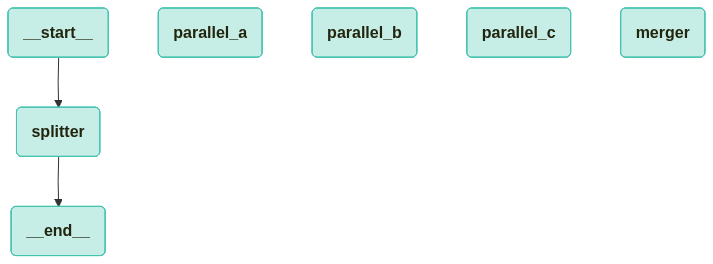

In [27]:
# 그래프 시각화
visualize_graph(parallel_graph, xray=True)

In [28]:
from langchain_teddynote.messages import invoke_graph

start_time = time.time()
invoke_graph(
    parallel_graph, inputs={"input": 1, "nodes": "ca", "results": []}, config=None
)
elapsed = time.time() - start_time

print(f"\n실행 시간: {elapsed:.1f}초 (병렬 실행으로 시간 단축)")

[Parallel Routing] ca

🔄 Node: splitter 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
분할 완료
[Node A]
[Node C]

🔄 Node: parallel_a 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
A: 2

🔄 Node: parallel_c 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
C: 1

🔄 Node: merger 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
병합 완료

실행 시간: 2.0초 (병렬 실행으로 시간 단축)


---

## Send - 동적 라우팅

### Send 개념

Send는 실행 시점에 동적으로 여러 노드를 호출할 수 있는 기능입니다.

**주요 특징**

- **동적 노드 호출**: 실행 시점에 호출할 노드 수 결정
- **개별 상태 전달**: 각 노드에 서로 다른 상태값 전달
- **Map-Reduce 패턴**: 작업 분할 → 병렬 처리 → 결과 통합

**사용 시나리오**

- 대용량 데이터 병렬 처리
- 동적 스케일링
- 배치 처리
- 조건부 병렬화

**사용 예시**

```python
def dynamic_router(state):
    sends = []
    for item in state["items"]:
        sends.append(Send("process_item", {"item": item}))
    return sends

builder.add_conditional_edges("splitter", dynamic_router, ["process_item"])
```

In [29]:
from typing import TypedDict, List, Annotated, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, AnyMessage
from langgraph.types import Send
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
import random

# ChatGPT 모델 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)


# State 정의
class JokeGeneratorState(TypedDict):
    """농담 생성 상태"""

    jokes: Annotated[List[AnyMessage], add_messages]
    current_subject: str
    attempt_count: int


class SingleJokeState(TypedDict):
    """개별 농담 생성 상태"""

    subject: str
    joke_number: int


# StateGraph 생성
builder = StateGraph(JokeGeneratorState)


def initialize_state(state: JokeGeneratorState) -> dict:
    """초기 상태 설정"""
    subjects = ["프로그래머", "AI", "파이썬", "자바스크립트", "데이터베이스"]
    selected_subject = random.choice(subjects)

    print(f"선택된 주제: {selected_subject}")
    print("=" * 50)

    return {"current_subject": selected_subject, "jokes": [], "attempt_count": 0}


def generate_single_joke(state: SingleJokeState) -> dict:
    """LLM을 사용하여 개별 농담 생성"""
    messages = [
        SystemMessage(
            content="당신은 재미있는 IT 농담을 만드는 코미디언입니다. 짧고 재치있는 농담을 한국어로 만들어주세요."
        ),
        HumanMessage(
            content=f"{state['subject']}에 대한 재미있는 농담을 하나만 만들어주세요. (농담 #{state['joke_number']})"
        ),
    ]

    response = llm.invoke(messages)
    joke = response.content.strip()

    print(f"농담 #{state['joke_number']}: {joke}")

    return {"jokes": [joke]}


def update_attempt_count(state: JokeGeneratorState) -> dict:
    """시도 횟수 업데이트"""
    attempt_count = state.get("attempt_count", 0) + 1
    current_joke_count = len(state.get("jokes", []))

    print(f"\n현재 농담 개수: {current_joke_count}/3")
    print(f"시도 횟수: {attempt_count}")

    return {"attempt_count": attempt_count}


def route_based_on_count(state: JokeGeneratorState) -> List[Send]:
    """농담 개수에 따라 Send로 라우팅"""
    current_joke_count = len(state.get("jokes", []))

    if current_joke_count < 3:
        # 3개 미만이면 부족한 만큼 generate_joke로 Send
        sends = []
        for i in range(current_joke_count + 1, 4):  # 3개까지 생성
            sends.append(
                Send(
                    "generate_joke",
                    {"subject": state["current_subject"], "joke_number": i},
                )
            )
        print(f"{len(sends)}개의 농담을 추가로 생성합니다...")
        return sends
    else:
        # 3개 이상이면 finalize로
        print("농담 3개 생성 완료! 최종 정리 단계로 이동합니다.")
        return [Send("finalize", state)]


def finalize_jokes(state: JokeGeneratorState) -> dict:
    """최종 농담 정리"""
    print("\n" + "=" * 50)
    print(f"최종 농담 컬렉션 ({state['current_subject']} 주제)")
    print("=" * 50)

    jokes = state.get("jokes", [])
    for i, joke in enumerate(jokes, 1):
        print(f"\n농담 {i}: {joke}")

    summary = f"\n\n총 {len(jokes)}개의 농담이 생성되었습니다. (시도 횟수: {state.get('attempt_count', 1)}회)"

    return {"jokes": jokes + [summary]}


# 노드 추가
builder.add_node("initialize", initialize_state)
builder.add_node("generate_joke", generate_single_joke)
builder.add_node("update_count", update_attempt_count)
builder.add_node("finalize", finalize_jokes)

# 엣지 추가
builder.add_edge(START, "initialize")
builder.add_edge("initialize", "update_count")

# update_count 노드 이후 conditional_edges로 Send 처리
builder.add_conditional_edges(
    "update_count",
    route_based_on_count,  # Send 리스트를 반환하는 라우팅 함수
    ["generate_joke", "finalize"],  # 가능한 목적지 노드들
)

# generate_joke 완료 후 다시 update_count로
builder.add_edge("generate_joke", "update_count")

# finalize 후 종료
builder.add_edge("finalize", END)

# 그래프 컴파일
joke_generator = builder.compile()

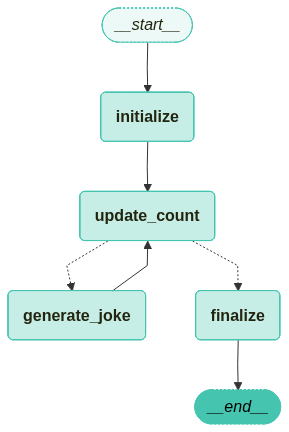

In [30]:
visualize_graph(joke_generator)

In [31]:
from langchain_teddynote.messages import stream_graph

stream_graph(
    joke_generator,
    inputs={"current_subject": "AI", "jokes": [], "attempt_count": 0},
    config=None,
)

🎯 선택된 주제: AI

📊 현재 농담 개수: 0/3
🔄 시도 횟수: 1
➡️ 3개의 농담을 추가로 생성합니다...

🔄 Node: generate_joke 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
왜 AI는 항상 친구가 필요할왜 AI까요?는 항상 

왜 자신감을냐하면 "혼 가지고 있을까요? 

왜냐하면자서 학습, 항상"하는왜 AI는 항상 좋은 친구가 될까요? "나는 건 너무 할 수 

왜냐하면 외롭거든 항상 " 있어!"요!너를🎭 농담 #1: 왜 AI는 항상 친구가 필요할까요? 

왜냐하면 "혼자서 학습"하는 건 너무 외롭거든요!
라고 코 이해해딩되어"라고 있으니까요!🎭 농담 #2: 왜 AI는 항상 자신감을 가지고 있을까요? 

왜냐하면, 항상 "나는 할 수 있어!"라고 코딩되어 있으니까요!
 말하니까요!🎭 농담 #3: 왜 AI는 항상 좋은 친구가 될까요? 

왜냐하면 항상 "너를 이해해"라고 말하니까요!

📊 현재 농담 개수: 3/3
🔄 시도 횟수: 2
✅ 농담 3개 생성 완료! 최종 정리 단계로 이동합니다.

🎉 최종 농담 컬렉션 (AI 주제)

농담 1: content='왜 AI는 항상 친구가 필요할까요? \n\n왜냐하면 "혼자서 학습"하는 건 너무 외롭거든요!' additional_kwargs={} response_metadata={} id='66fc6092-1d50-4f4a-b51a-2988ec57cced'

농담 2: content='왜 AI는 항상 자신감을 가지고 있을까요? \n\n왜냐하면, 항상 "나는 할 수 있어!"라고 코딩되어 있으니까요!' additional_kwargs={} response_metadata={} id='362d39cc-0401-4a2d-b1f1-1301d4d84448'

농담 3: content='왜 AI는 항상 좋은 친구가 될까요? \n\n왜냐하면 항상 "너를 이해해"라고 말하니까요!' additional_kwargs={} response_metadata={} id='

---

## Command - 통합 제어

### Command 개념

Command는 상태 업데이트와 제어 흐름을 동시에 처리할 수 있는 객체입니다.

**핵심 기능**

**update** - 상태 업데이트
```python
Command(
    update={
        "score": state["score"] + 10,
        "level": "advanced"
    }
)
```

**goto** - 제어 흐름
```python
Command(
    update={...},
    goto="next_stage"
)
```

**사용 시나리오**

- 상태 업데이트와 라우팅 동시 처리
- 멀티 에이전트 핸드오프
- 복잡한 비즈니스 로직 구현

### Command 활용

Command를 사용하면 상태 업데이트와 제어 흐름을 하나의 객체로 처리할 수 있습니다.

```python
Command(
    update={
        "treatment_status": "완료",
        "next_appointment": "2025-11-15",
        "bill_amount": 50000
    },
    goto="discharge" if recovered else "follow_up"
)
```

In [32]:
from langgraph.types import Command
from typing import Literal
from typing_extensions import TypedDict


class CommandState(TypedDict):
    """Command 예제를 위한 상태 정의"""

    value: int


def my_node(state: CommandState) -> Command[Literal["my_other_node"]]:
    """상태를 업데이트하고 결정을 내리는 노드"""
    return Command(
        # state update
        update={"foo": "bar"},
        # control flow
        goto="my_other_node",
    )

Command를 사용하면 조건부 엣지와 동일한 동적 제어 흐름을 구현할 수 있습니다.

In [33]:
def my_node(state: CommandState) -> Command[Literal["my_other_node"]]:
    if state["foo"] == "bar":
        return Command(update={"foo": "baz"}, goto="my_other_node")

### 상위 그래프로 이동

하위 그래프 내 노드에서 상위 그래프의 다른 노드로 이동하려면 `graph=Command.PARENT`를 지정합니다.

In [34]:
def my_node(state: CommandState) -> Command[Literal["other_subgraph"]]:
    return Command(
        update={"foo": "bar"},
        goto="other_subgraph",  # where `other_subgraph` is a node in the parent graph
        graph=Command.PARENT,
    )

### Command 통합 예제

`Command`를 사용하여 `update`와 `goto`를 동시에 사용하는 예제입니다.

In [35]:
from langgraph.types import Command


class CommandState(TypedDict):
    """Command 예제를 위한 상태 정의"""

    value: int
    message: str
    path: List[str]


builder = StateGraph(CommandState)


# Command를 반환하는 노드
def decision_node(
    state: CommandState,
) -> Command[Literal["success", "failure", "retry"]]:
    """상태를 업데이트하고 결정을 내리는 노드"""
    value = state["value"]

    if value > 100:
        return Command(
            # 상태 업데이트
            update={
                "message": "값이 너무 큽니다",
                "path": state["path"] + ["decision"],
            },
            # 라우팅
            goto="failure",
        )
    elif value > 50:
        return Command(
            update={
                "message": "처리 성공",
                "value": value * 2,
                "path": state["path"] + ["decision"],
            },
            goto="success",
        )
    else:
        return Command(
            update={
                "message": "재시도 필요",
                "value": value + 30,
                "path": state["path"] + ["decision"],
            },
            goto="retry",
        )


def success_node(state: CommandState):
    """성공 처리 노드"""
    return {"message": f"[성공] {state['message']}", "path": state["path"] + ["success"]}


def failure_node(state: CommandState):
    """실패 처리 노드"""
    return {"message": f"[실패] {state['message']}", "path": state["path"] + ["failure"]}


def retry_node(state: CommandState) -> Command[Literal["decision"]]:
    """재시도 처리 노드 - decision으로 되돌아감"""
    return Command(
        update={"message": "재시도 중...", "path": state["path"] + ["retry"]},
        goto="decision",  # 다시 결정 노드로
    )


# 노드 추가
builder.add_node("decision", decision_node)
builder.add_node("success", success_node)
builder.add_node("failure", failure_node)
builder.add_node("retry", retry_node)

# 엣지 추가
builder.add_edge(START, "decision")
builder.add_edge("success", END)
builder.add_edge("failure", END)
# retry는 Command로 decision으로 돌아감

command_graph = builder.compile()

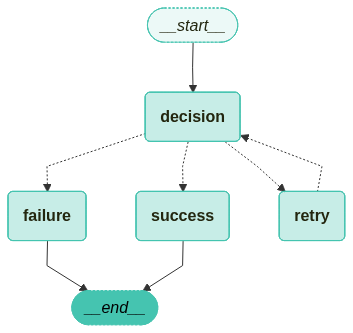

In [36]:
visualize_graph(command_graph)

In [37]:
# 그래프 실행
test_values = [30, 75, 150]
for val in test_values:
    result = command_graph.invoke({"value": val, "message": "", "path": []})
    print(f"초기값 {val}:")
    print(f"  경로: {' → '.join(result['path'])}")
    print(f"  메시지: {result['message']}")
    print(f"  최종값: {result['value']}\n")

초기값 30:
  경로: decision → retry → decision → success
  메시지: ✅ 처리 성공
  최종값: 120

초기값 75:
  경로: decision → success
  메시지: ✅ 처리 성공
  최종값: 150

초기값 150:
  경로: decision → failure
  메시지: ❌ 값이 너무 큽니다
  최종값: 150



### Command vs 조건부 엣지

**Command 사용 시**

- 상태 업데이트와 라우팅을 동시에 수행해야 할 때
- 멀티 에이전트 핸드오프에서 정보 전달이 필요할 때

**조건부 엣지 사용 시**

- 상태 업데이트 없이 라우팅만 필요할 때
- 단순한 분기 로직

In [38]:
# 멀티 에이전트 핸드오프 예제
class AgentState(TypedDict):
    """멀티 에이전트 시스템을 위한 상태 정의"""

    task: str
    current_agent: str
    result: str
    handoff_info: dict


builder = StateGraph(AgentState)


def analyst_agent(state: AgentState) -> Command[Literal["engineer", "designer"]]:
    """태스크를 위임하는 분석가 에이전트"""
    task = state["task"]

    if "코드" in task or "구현" in task:
        return Command(
            update={
                "current_agent": "engineer",
                "handoff_info": {
                    "priority": "high",
                    "language": "Python",
                    "analyzed_by": "analyst",
                },
            },
            goto="engineer",
        )
    else:
        return Command(
            update={
                "current_agent": "designer",
                "handoff_info": {"style": "modern", "analyzed_by": "analyst"},
            },
            goto="designer",
        )


def engineer_agent(state: AgentState):
    """엔지니어 에이전트"""
    info = state["handoff_info"]
    return {"result": f"엔지니어가 {info.get('language', 'unknown')}로 구현 완료"}


def designer_agent(state: AgentState):
    """디자이너 에이전트"""
    info = state["handoff_info"]
    return {"result": f"디자이너가 {info.get('style', 'unknown')} 스타일로 디자인 완료"}


# 노드 추가
builder.add_node("analyst", analyst_agent)
builder.add_node("engineer", engineer_agent)
builder.add_node("designer", designer_agent)

# 엣지 추가
builder.add_edge(START, "analyst")
builder.add_edge("engineer", END)
builder.add_edge("designer", END)

agent_graph = builder.compile()

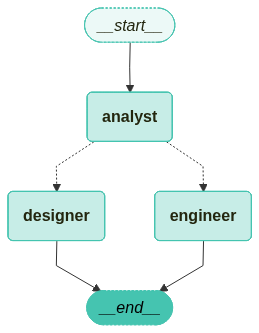

In [39]:
visualize_graph(agent_graph)

In [40]:
# 테스트
print("멀티 에이전트 핸드오프 테스트:\n")

tasks = ["로그인 기능 구현", "홈페이지 디자인"]
for task in tasks:
    result = agent_graph.invoke(
        {"task": task, "current_agent": "analyst", "result": "", "handoff_info": {}}
    )
    print(f"작업: {task}")
    print(f"  담당 에이전트: {result['current_agent']}")
    print(f"  전달 정보: {result['handoff_info']}")
    print(f"  결과: {result['result']}\n")

멀티 에이전트 핸드오프 테스트:

작업: 로그인 기능 구현
  담당 에이전트: engineer
  전달 정보: {'priority': 'high', 'language': 'Python', 'analyzed_by': 'analyst'}
  결과: 엔지니어가 Python로 구현 완료

작업: 홈페이지 디자인
  담당 에이전트: designer
  전달 정보: {'style': 'modern', 'analyzed_by': 'analyst'}
  결과: 디자이너가 modern 스타일로 디자인 완료



---

## 고급 기능

### 재귀 제한 (Recursion Limit)

무한 루프를 방지하기 위해 그래프 실행의 최대 super-step 수를 제한할 수 있습니다.

In [41]:
class LoopState(TypedDict):
    """루프 예제를 위한 상태 정의"""

    counter: int
    history: List[int]


builder = StateGraph(LoopState)


def increment_node(state: LoopState) -> Command[Literal["increment", "end"]]:
    """카운터를 증가시키는 노드"""
    new_counter = state["counter"] + 1

    print(f"new_counter: {new_counter}")

    if new_counter < 10:  # 의도적으로 높은 목표 설정
        return Command(
            update={
                "counter": new_counter,
                "history": state["history"] + [new_counter],
            },
            goto="increment",  # 자기 자신으로 루프
        )
    else:
        return Command(update={"counter": new_counter}, goto="end")


def end_node(state: LoopState):
    """종료 노드"""
    return {"history": state["history"] + [999]}


builder.add_node("increment", increment_node)
builder.add_node("end", end_node)
builder.add_edge(START, "increment")
builder.add_edge("end", END)

loop_graph = builder.compile()

# 재귀 제한 설정
print("재귀 제한 테스트:\n")

try:
    # 재귀 제한 5로 실행
    result = loop_graph.invoke(
        {"counter": 0, "history": []}, config={"recursion_limit": 5}  # 최대 5번만 실행
    )
except Exception as e:
    print(f"에러 발생: {e}")

재귀 제한 테스트:

new_counter: 1
new_counter: 2
new_counter: 3
new_counter: 4
new_counter: 5
❌ 에러 발생: Recursion limit of 5 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


In [42]:
# 충분한 재귀 제한으로 실행
result = loop_graph.invoke(
    {"counter": 0, "history": []}, config={"recursion_limit": 100}
)
print(f"\n성공: counter={result['counter']}, 실행 횟수={len(result['history'])}")

new_counter: 1
new_counter: 2
new_counter: 3
new_counter: 4
new_counter: 5
new_counter: 6
new_counter: 7
new_counter: 8
new_counter: 9
new_counter: 10

✅ 성공: counter=10, 실행 횟수=10
